## Insurance Dataset
The goal of this project is to a) preform an exploratory data analysis (EDA) and b) use regression techniques to predict Premium Amounts for an insurance dataset. \
The dataset used was synthetically generated for a Kaggle comeptition (see: https://www.kaggle.com/competitions/playground-series-s4e12/overview). 

### EDA

In [ ]:
#Import packages
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

import optuna
import lightgbm as lgb

In [ ]:
#Read in data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

In [ ]:
#Check shape of data frames
print(f"Training data has shape: {train_df.shape}")
print(f"Testing data has shape: {test_df.shape}")

Training data has shape: (1200000, 23)
Testing data has shape: (800000, 20)


One interesting observation here is that the testing dataframe has one less column. Let's look into that:

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   787511 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         770140 non-null  float64
 4   Marital Status        787664 non-null  object 
 5   Number of Dependents  726870 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            560875 non-null  object 
 8   Health Score          750551 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       557198 non-null  float64
 12  Vehicle Age           799997 non-null  float64
 13  Credit Score          708549 non-null  float64
 14  Insurance Duration    799998 non-null  float64
 15  

It seems like this is simply due to the test data not including the target variable 'Premium Amount'. \
Other observations here are that the data contains both numeric and non-numeric columns (these non-numeric columns will have to be converted to a more useable format at some point), and several columns have missing values (these also will have to be dealt with later). Besides that, all column names are fairly self-explanatory, with the exception of health score. Unfortunately, the source for the dataset doesn't detail what exactly this health score is, so I will assume it's some sort of measure of an individuals overall health.  \
Now I'll look more into the numeric columns:

In [7]:
#summary statistics for numeric columns
train_df.describe()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1.200000e+06,1.181295e+06,1.155051e+06,1.090328e+06,1.125924e+06,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1.200000e+06
mean,5.999995e+05,4.114556e+01,3.274522e+04,2.009934e+00,2.561391e+01,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,1.102545e+03
std,3.464103e+05,1.353995e+01,3.217951e+04,1.417338e+00,1.220346e+01,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,8.649989e+02
min,0.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00,2.012237e+00,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,2.000000e+01
25%,2.999998e+05,3.000000e+01,8.001000e+03,1.000000e+00,1.591896e+01,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,5.140000e+02
50%,5.999995e+05,4.100000e+01,2.391100e+04,2.000000e+00,2.457865e+01,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,8.720000e+02
75%,8.999992e+05,5.300000e+01,4.463400e+04,3.000000e+00,3.452721e+01,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,1.509000e+03
max,1.199999e+06,6.400000e+01,1.499970e+05,4.000000e+00,5.897591e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03


Nothing seems out of the ordinary here. Next, I'll plot some histograms to look more into each variable:

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


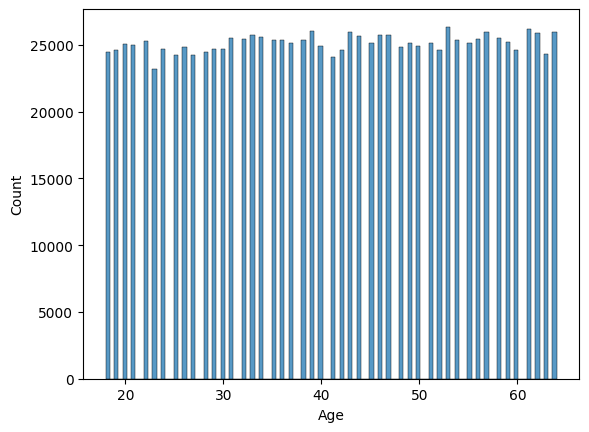

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


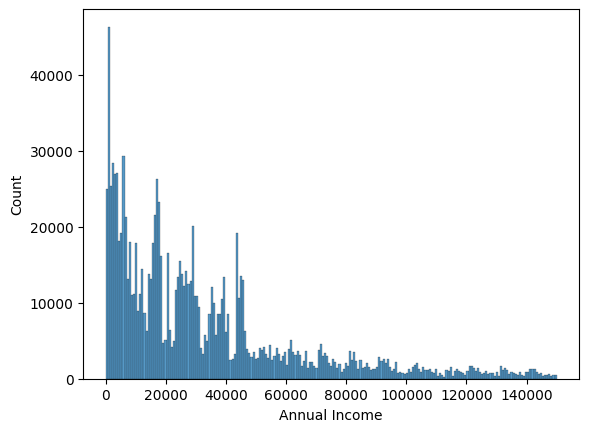

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


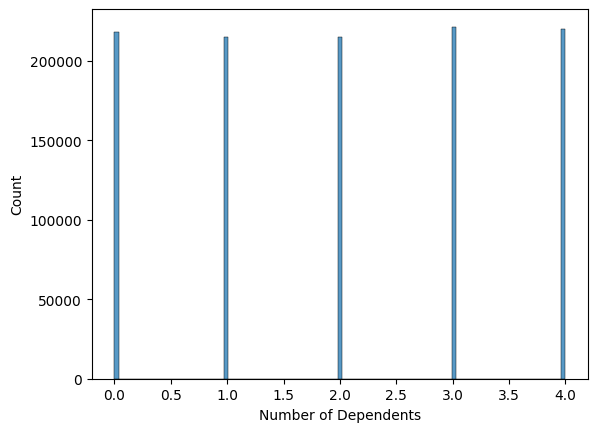

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


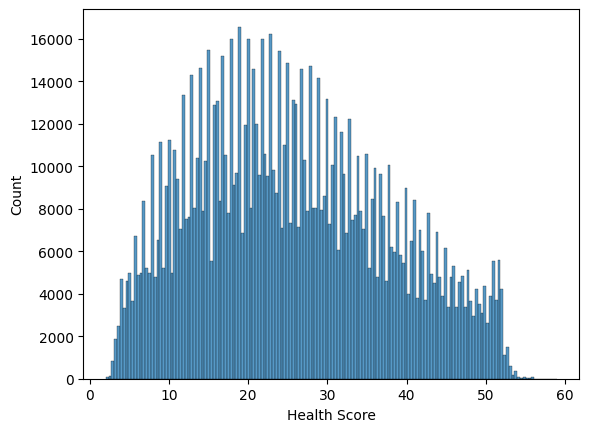

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


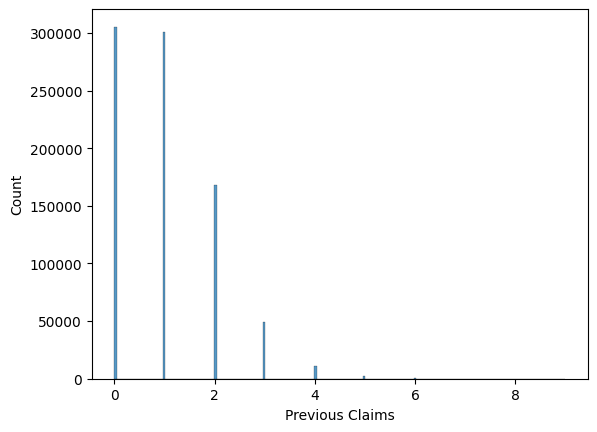

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


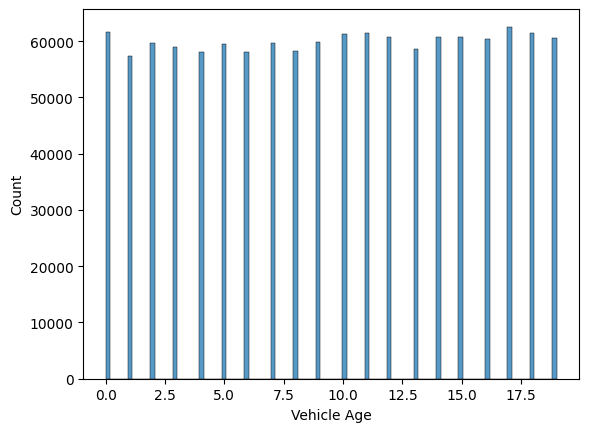

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


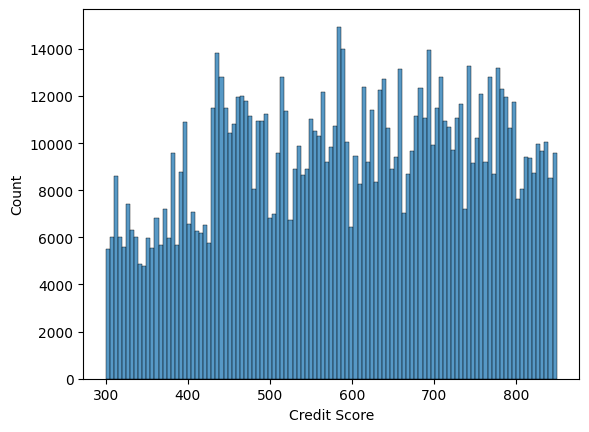

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


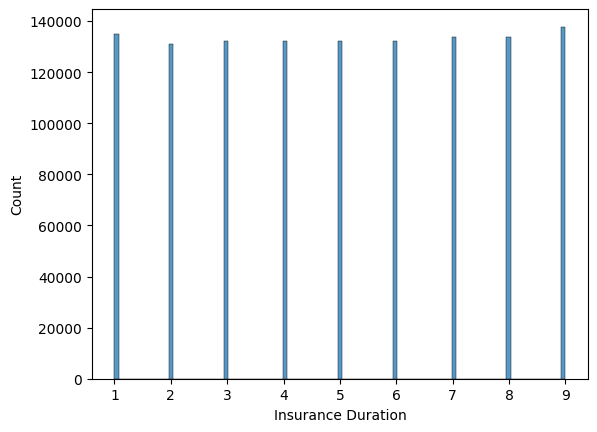

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


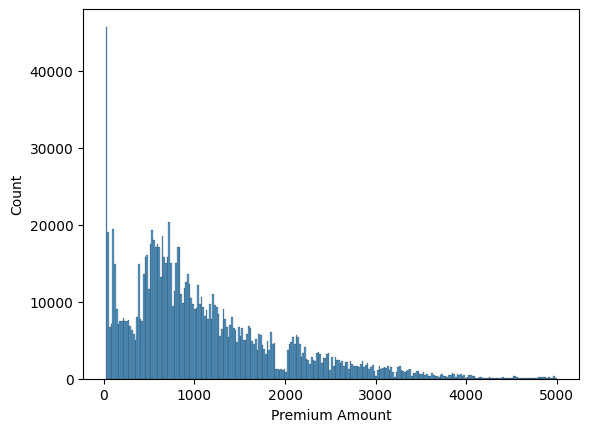

In [42]:
#histplots for each numeric variable
for i in train_df.select_dtypes(include = ['float64']).columns:
    #histplot
    sns.histplot(data=train_df, x=i)
    plt.show()

Some obseravations for each variable: \
Age - has a uniform distribution. This is suprising since age usually looks more like a normal distribution. \
Annual Income - has an exponential distribution. Significant portion of observations with zero income. \
Number of Dependents - uniformly distributed between 0-4. \
Health Score - somewhat normally distributed, right skewed with very small tails. \
Previous Claims - somewhat exponential distribution. Most observations have 0 or 1 previous claim. \
Vehicle Age - has a uniform distribution. Also suprising this is not normal... \
Credit Score - doesn't really follow any clear distribution. \
Insurance Duration - has a uniform distribution. Not sure if this one is a suprise or not. \
Premium Amount - somewhat exponential distribution. Lots of observations with premium amount equal to zero. 

Next I'll look at a correlation matrix of the numeric columns:

<Axes: >

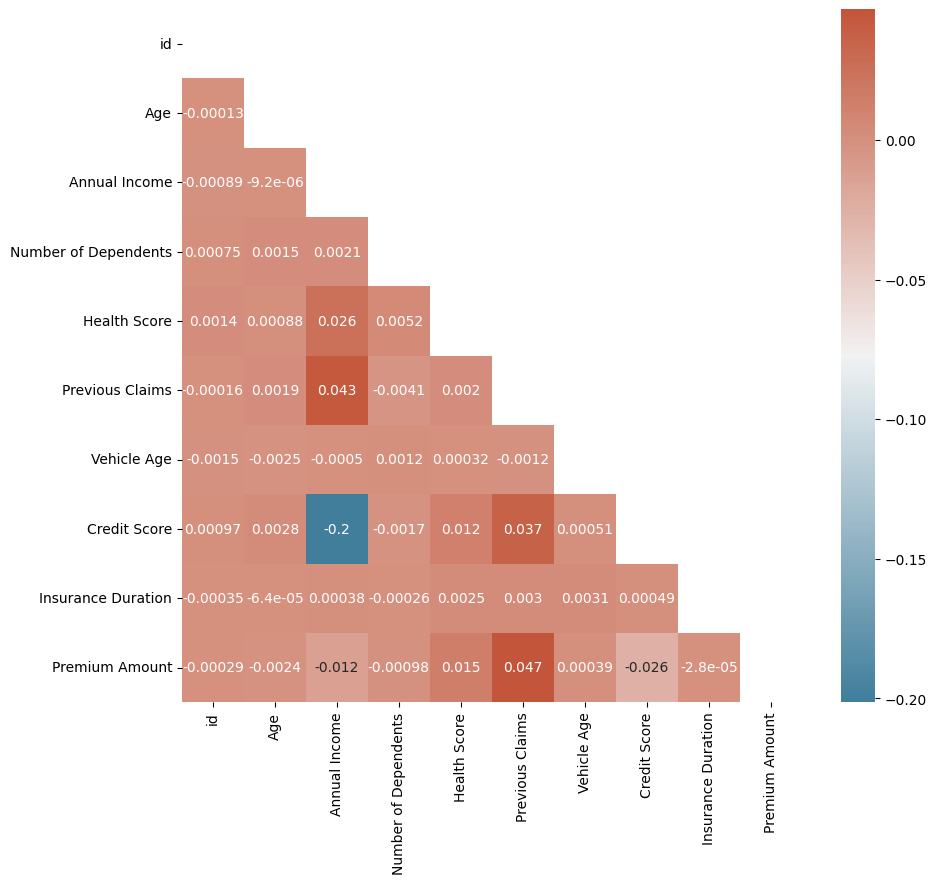

In [40]:
correlation = train_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(correlation, dtype=bool))
f, ax = plt.subplots(figsize=(10, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, annot=True)

None of the numeric values have a particularly strong correlation with the target variable. Previous claims has the highest correlation, which intuitively makes sense. \
Now I'll move on to categorical (non-numeric) variables:

In [46]:
#number of categories in each categorical variable
for i in train_df.select_dtypes(include = ['object']).columns:
    print (f'Value Count for {i}')
    print(train_df[i].value_counts())
    print('-'*20)

Value Count for Gender
Gender
Male      602571
Female    597429
Name: count, dtype: int64
--------------------
Value Count for Marital Status
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64
--------------------
Value Count for Education Level
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64
--------------------
Value Count for Occupation
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64
--------------------
Value Count for Location
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64
--------------------
Value Count for Policy Type
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64
--------------------
Value Count for Policy Start Date
Policy Start Date
2020-02-08 15:21:39.134960    142
2023-08-13 15:21

The number of observations in each category is roughly the same each category. Additionally, all variables have a relatively small number of categories so it should be possible to one-hot encode them later.

Now look at a countplot and boxplot for each variable:

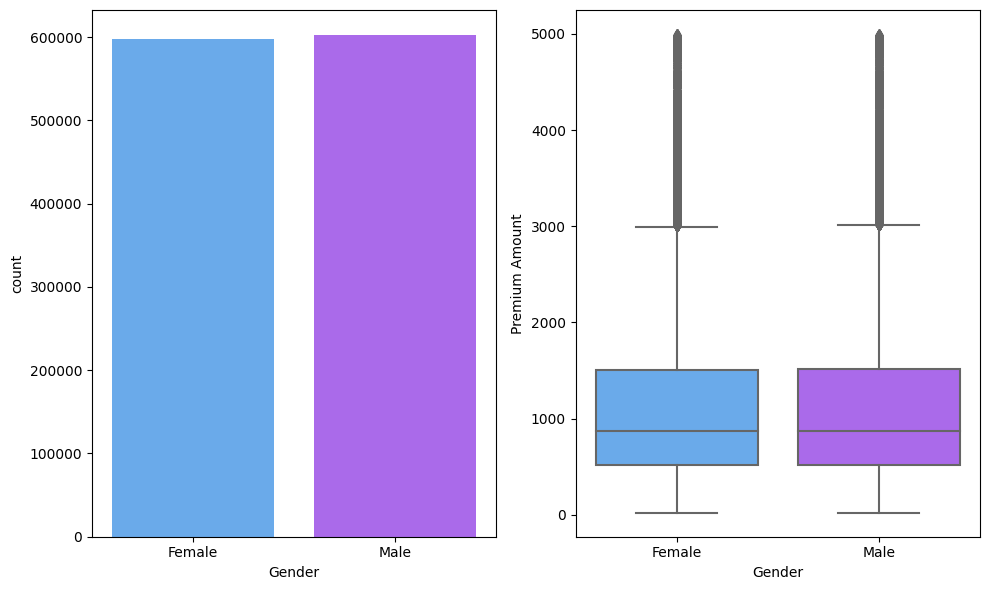

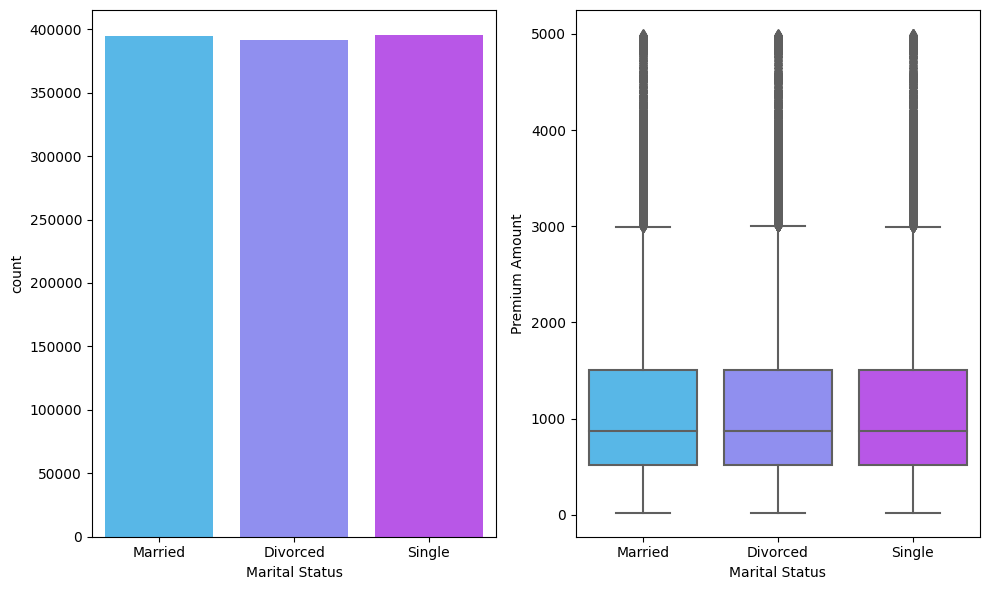

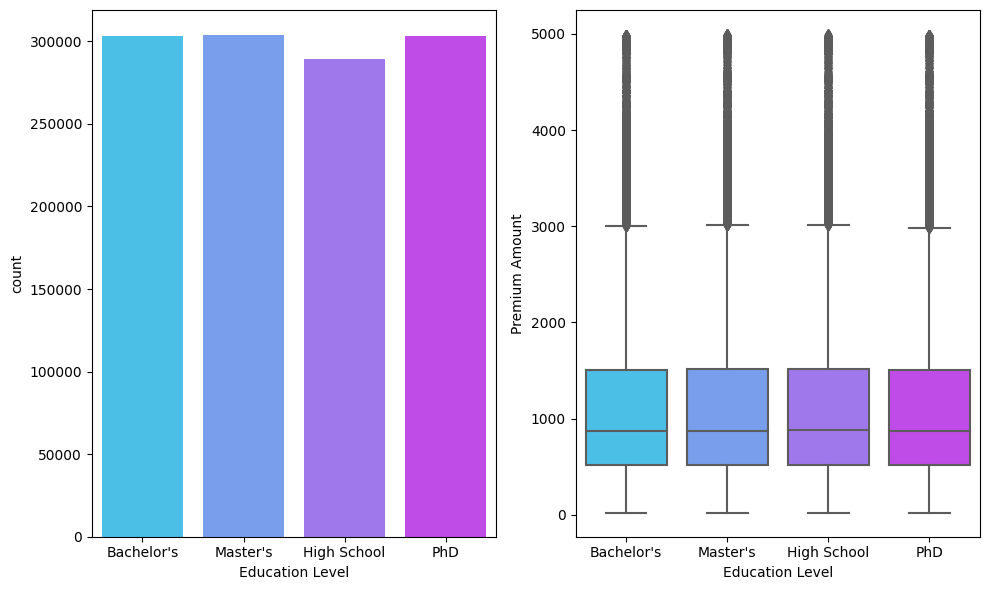

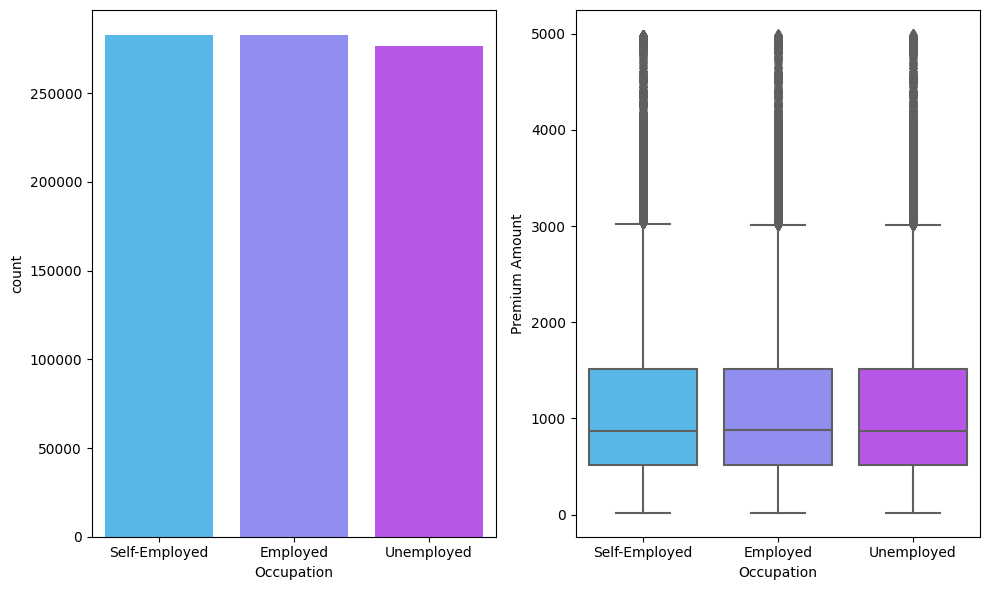

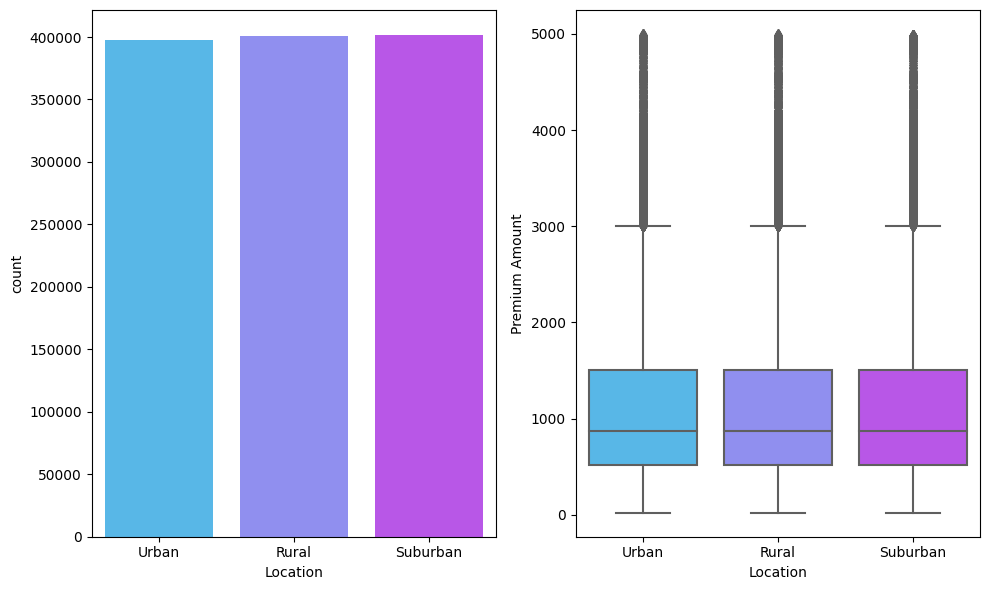

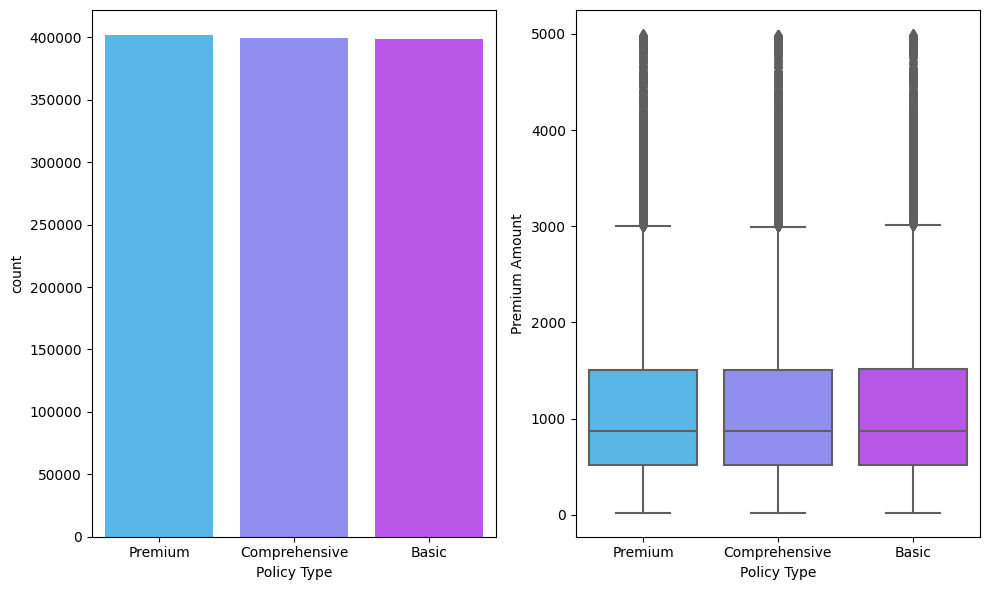

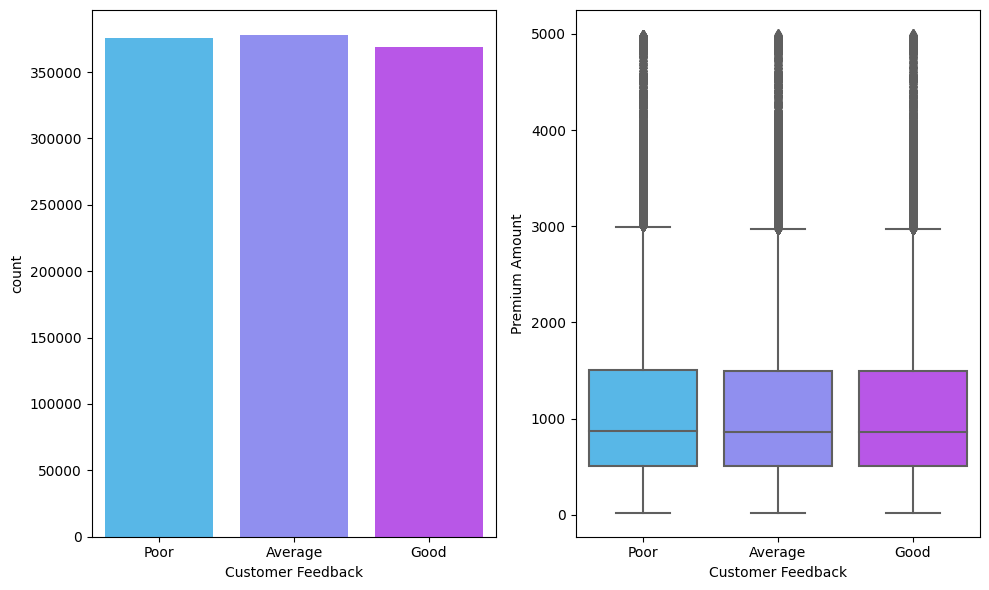

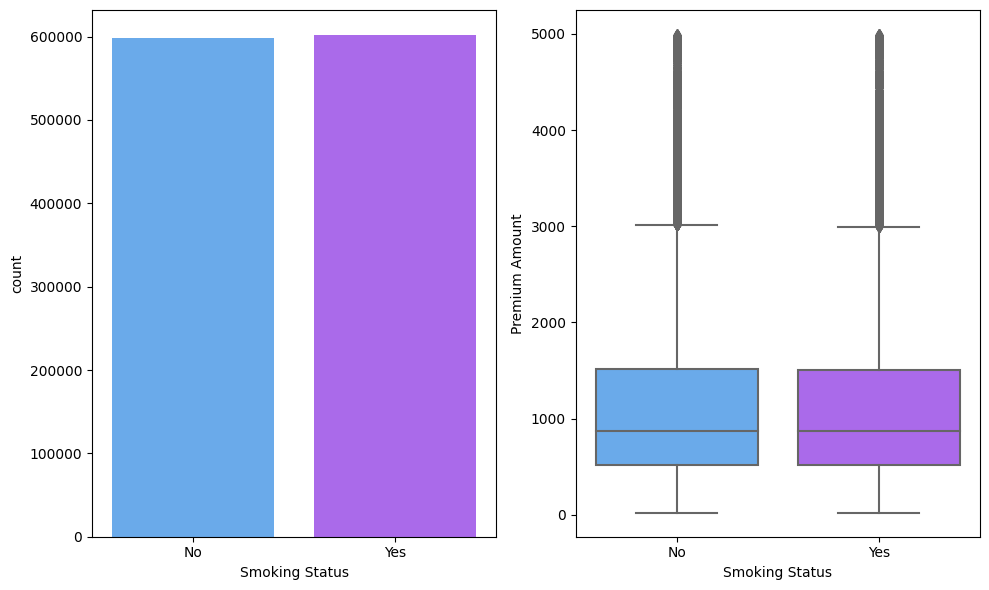

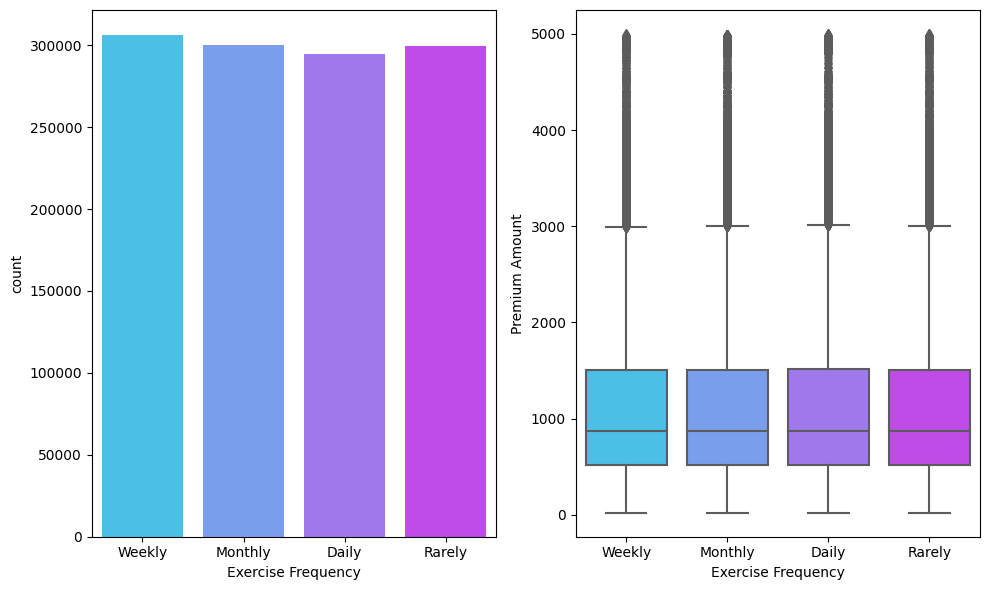

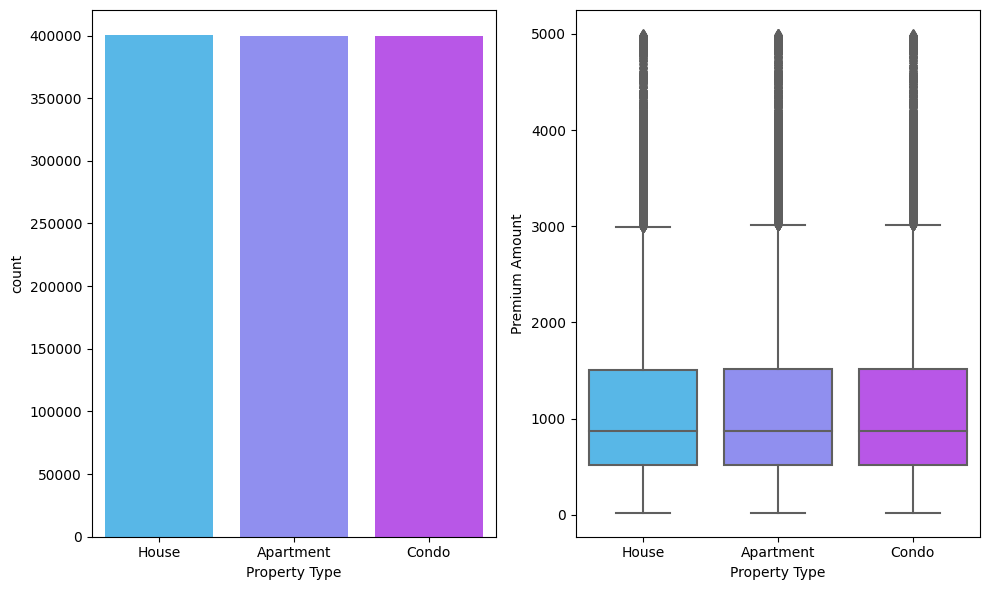

In [55]:
#countplots and boxplots for each categorical variable
for i in train_df.select_dtypes(include = ['object']).columns:
    #CountPlot
    fig , axes = plt.subplots(1,2 , figsize=(10,6))
    sns.countplot(data=train_df, x=i, palette='cool', ax= axes[0])
    #BoxPlot
    sns.boxplot(data=train_df , x=i , y=train_df.loc[:,'Premium Amount'] ,palette= 'cool', ax= axes[1])
    plt.tight_layout()
    plt.show()

It is very interesting that every category for every variable has a roughly equal number of observations in it. It is also interesting that none of the categories seem to correlate with the premium amount significantly. \
Now I'll return to the issue of missing data and fill in each missing value appropiately:

In [8]:
train_df.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
Year                         0
Month                        0
dtype: int64

In [13]:
num_col = train_df.select_dtypes(include = ['float64']).columns
cat_col = train_df.select_dtypes(include = ['object']).columns
#numeric column imputation
median_imp = SimpleImputer(strategy='median')
train_df[num_col] = median_imp.fit_transform(train_df.select_dtypes(include = ['float64']))
#categorical columns imputation
const_imp = SimpleImputer(strategy='constant', fill_value='Unknown')
train_df[cat_col] = const_imp.fit_transform(train_df.select_dtypes(include = ['object']))

In [14]:
#same as above for test_df
num_col = test_df.select_dtypes(include = ['float64']).columns
cat_col = test_df.select_dtypes(include = ['object']).columns
test_df[num_col] = median_imp.fit_transform(test_df.select_dtypes(include = ['float64']))
test_df[cat_col] = const_imp.fit_transform(test_df.select_dtypes(include = ['object']))

In [45]:
train_df.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

Now that missing values have been dealt with, I can move onto duplicate rows:

In [12]:
train_df.duplicated().sum()

0

No duplicates present. Next, I'll drop the columns related to date and split the data:

In [15]:
X = train_df.drop(columns=['Premium Amount', 'id', 'Policy Start Date'])
y = train_df['Premium Amount']

In [16]:
X_test = test_df.drop(columns=['id', 'Policy Start Date'])

Moving onto encoding the categorical variables and scaling the numeric variables:

In [17]:
num_col = X.select_dtypes(include = ['float64']).columns
cat_col = X.select_dtypes(include = ['object']).columns

num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_col),
        ('cat', cat_pipeline, cat_col)
    ]
)
X = preprocessor.fit_transform(X)

In [18]:
#same for test_df
num_col = X_test.select_dtypes(include = ['float64']).columns
cat_col = X_test.select_dtypes(include = ['object']).columns
X_test = preprocessor.transform(X_test)

The last thing to do in this section is to split the data into a training and validation set. The validation set will be useful in the next section for evaluating the model and tuning hyperparameters.

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

### Regression
In this section I'll use regression techniques to predict the Premium Amount. I'm going to focus on using tree based techniques here such as bagging, random forests, and gradient boosting (using LightGBM). \
Starting with bagging:

In [25]:
bag_reg = BaggingRegressor(n_estimators=50).fit(X_train, y_train)

#evaluate on validation set
y_val_pred_bag = bag_reg.predict(X_val)
rmsle_bag = mean_squared_log_error(y_val, y_val_pred_bag)

In [26]:
#for reference rmsle was: 1.33
rmsle_bag

1.3321875976321778

Its important to note here that more work could be done to improve the results of bagging via tuning the hyperparameters (number of estimators (B), number of samples per estimator). However, I'm going to skip over this step for this model and the next and instead opt to solely focus on hyperparameter tuning for the gradient boosting model as I expect it to have the best results. \
Moving onto the random forest model:

In [27]:
#create and fit random forest model
rand_reg = RandomForestRegressor(n_estimators=50).fit(X_train,y_train)

#evaluate on validation set
y_val_pred_rand = rand_reg.predict(X_val)
rmsle_rand = mean_squared_log_error(y_val, y_val_pred_rand)

In [28]:
#for reference rmsle was: 1.33
rmsle_rand

1.3321871088281259

Once again, there are several more hyperparameters for the random forest model that could be tuned but I'll move forward to gradient boosting using the LightGBM library. \
Additionally, I'll be using the optuna library to optimize the hyperparameters of the model. Specifically, I'll be optimizing for Root Mean Squared Log Error as this is the chosen error metric for the competition:

In [ ]:
# Define Optuna optimization function
def objective(trial):
    # Define parameter search space
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 200, 512),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-4, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 10.0)
    }

    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # Train LightGBM model
    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    mse = mean_squared_log_error(y_val, y_val_pred, squared=False)
    return mse

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

After running the study the best hyperparameters are found and can be saved in a dictionary:

In [23]:
study.best_params

{'boosting_type': 'dart',
 'num_leaves': 416,
 'learning_rate': 0.01672028471427857,
 'feature_fraction': 0.9116270298700753,
 'bagging_fraction': 0.8916083168638901,
 'bagging_freq': 5,
 'min_data_in_leaf': 94,
 'max_depth': 15,
 'lambda_l1': 0.01091718650645734,
 'lambda_l2': 9.521822399424385}

In [30]:
#save best hyperparameters
best_params = {'boosting_type': 'dart',
 'num_leaves': 416,
 'learning_rate': 0.01672028471427857,
 'feature_fraction': 0.9116270298700753,
 'bagging_fraction': 0.8916083168638901,
 'bagging_freq': 5,
 'min_data_in_leaf': 94,
 'max_depth': 15,
 'lambda_l1': 0.01091718650645734,
 'lambda_l2': 9.521822399424385}

#for reference the validation set mse of this model was: 1.075

Now that the optimized hyperparameters have been found, I will train the model on the full training dataset:

In [31]:
lgb_reg = lgb.train(
    best_params,
    lgb.Dataset(X, label=y),
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 41
[LightGBM] [Info] Start training from score 1102.544822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Before creating a submission, I'll look at what the most important features in the model were:

<Axes: xlabel='Importance', ylabel='Feature'>

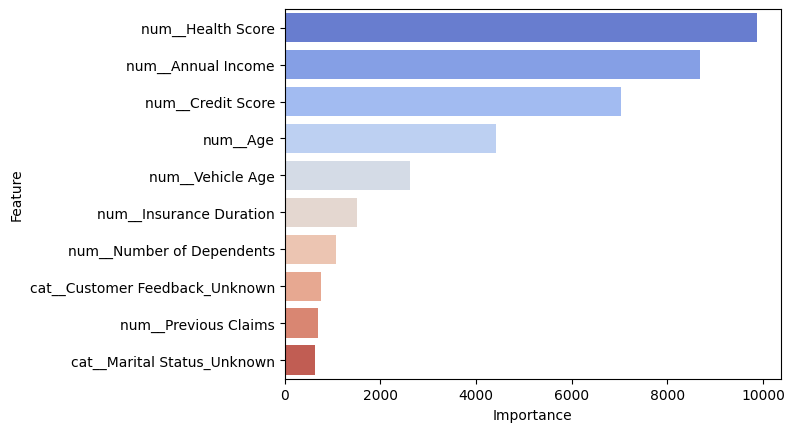

In [32]:
importances = lgb_reg.feature_importance(importance_type='split')
features = preprocessor.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")

Health score, annual income, and credit score are the 3 most important features in the final model. It is interesting to note that although previous claims had the highest correlation with Premium Amount, it is only the 9th most important feature in the final model.\
Finally, we can predict values for the testing set and create a competition submission:

In [33]:
test_predictions = lgb_reg.predict(X_test, num_iteration=lgb_reg.best_iteration)

# Prepare submission file
submission = pd.DataFrame({'id': test_df['id'], 'Premium Amount': test_predictions})
submission.to_csv("submission.csv", index=False)

After submitting to the competition, my models final test rmsle was: 1.08212 \
The winners of the competition had rmsle closer to: 1.02

To improve my final models performance further, I would likely have to put more effort into feature engineering. Particularly into better ways to represent the date column, as this was left out of my final model.